# 5.2 합성곱 신경망 맛보기

In [1]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리 사용 목적 라이브러리
from torch.utils.data import Dataset, DataLoader

In [2]:
# GPU 자치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # 하나의 GPU
# device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model=Net()
# model.to(device)

# # 여러 GPU
# # DataParallel이 배치 크기(batch size)가 알아서 각 GPU로 분배되는 방식으로 작동하므로 GPU 수만큼 배치 크기 늘려야함
# if torch.cuda.device_count() >1:
# 	model=nn.DataParallel(net)
# model.to(device)

In [3]:
# 데이터셋 내려받기
train_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:00<00:00, 115898080.60it/s]


Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 96714752.00it/s]

Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 70562518.00it/s]


Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18973881.36it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



In [4]:
# 데이터 로더에 데이터 전달
# DataLoader: 데이터를 메모리로 불러오기 위해 사용
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

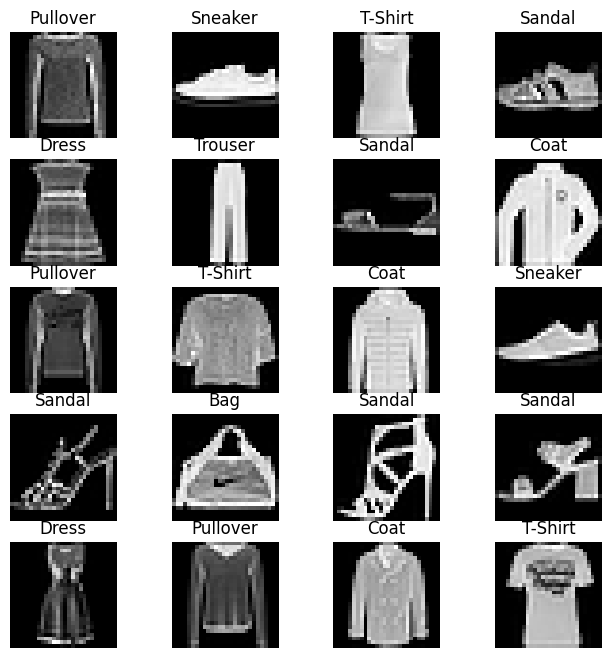

In [5]:
# 분류 클래스 정의
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8)); # 출력할 이미지의 가로 세로 길이(inch)
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    # np.random.randint: 이산형 분포를 갖는 데이터에서 무작위 표본 추출 시 사용
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show() # 20개의 이미지를 시각적으로 표현

In [6]:
# DNN 모델 생성
class FashionDNN(nn.Module):
    # 객체가 갖는 속성 값 초기화. 객체 생성 시 자동 호출
    def __init__(self):
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=784,out_features=256)
        # torch.nn.Dropout(p): p만큼의 비율로 텐서의 값이 0, 0이 되지 않는 값들은 기존 값*(1/(1-p))
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)

    # 모델이 학습 데이터를 입력받아 순전파 학습을 진행. 객체를 데이터와 함께 호출 시 자동 실행
    def forward(self,input_data):
        # view: 텐서 크기 변경
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [7]:
# DNN에서 필요한 파라미터 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate); # Adam을 사용하여 모델의 파라미터를 업데이트
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
# DNN을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader: # for x , y in train
        images, labels = images.to(device), labels.to(device)

        # torch.autograd 안에 있는 Variable을 이용해야 자동 미분 동작
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train) # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels) # 모델의 출력(outputs)과 실제 레이블(labels)을 비교하여 손실을 계산
        optimizer.zero_grad() # 기존 기울기 초기화
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트
        count += 1

        if not (count % 50): # count를 50으로 나눴을 때 나머지가 0이 아니라면 실행
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.6004664897918701, Accuracy: 83.37999725341797%
Iteration: 1000, Loss: 0.4670983850955963, Accuracy: 84.45999908447266%
Iteration: 1500, Loss: 0.38249900937080383, Accuracy: 84.79999542236328%
Iteration: 2000, Loss: 0.37223419547080994, Accuracy: 85.75%
Iteration: 2500, Loss: 0.24654912948608398, Accuracy: 86.04000091552734%
Iteration: 3000, Loss: 0.3190401494503021, Accuracy: 86.97000122070312%


In [9]:
# CNN 모델 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # nn.Sequential: init에서 사용할 네트워크 모델 정의 + forward에서 구현될 순전파를 layer 형태로 가독성이 좋은 코드 작성 가능
        self.layer1 = nn.Sequential(
            # 합성곱 연산을 통해 이미지 특징 추출
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            # 학습 과정에서 각 배치 단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용해 정규화
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # 이미지 크기 축소 용도
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 클래스 분류하려면 이미지 형태의 데이터를 배열 형태로 변환해야 함
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [10]:
# CNN 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [11]:
# CNN 모델 학습 및 성능 평가
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5336249470710754, Accuracy: 87.25%
Iteration: 1000, Loss: 0.3208913505077362, Accuracy: 88.02999877929688%
Iteration: 1500, Loss: 0.2954282760620117, Accuracy: 87.29000091552734%
Iteration: 2000, Loss: 0.21413646638393402, Accuracy: 89.22000122070312%
Iteration: 2500, Loss: 0.1622927337884903, Accuracy: 89.97999572753906%
Iteration: 3000, Loss: 0.13018184900283813, Accuracy: 90.43000030517578%
